In [24]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from contextlib import contextmanager
from itertools import islice

from oil.cnnTrainer import CnnTrainer
from oil.datasets import CIFAR10, C10augLayers
from oil.networkparts import layer13, ConvSmallNWN
from oil.schedules import cosLr
from oil.utils import to_gpu
from oil.extra.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag
from oil.extra.mvm import get_eigs,get_eigs_l, Hvm, Fvm, flatten, to_matmul,add, Fvm2
from oil.extra.mvm import autoHvpBatch,autoFvpBatch, fdHvpBatch, fdFvpBatch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CNN Configuration

In [261]:
train_epochs = 150
net_config =        {'numClasses':10}
opt_config =        {'lr':.1, 'momentum':.9, 'weight_decay':1e-4, 'nesterov':True}
sched_config =      {'cycle_length':train_epochs,'cycle_mult':1}
trainer_config =    {'amntLab':1, 'amntDev':5000,'dataseed':0,
                    'lab_BS':50, 'num_workers':4, 'log':False, 
                    }
trainer_config['description'] = "13Layer network, {} dev".format(trainer_config['amntDev'])
savedir = None#'/home/maf388/tb-experiments/layer13dev/'

def makeTrainer():
    CNN = ConvSmallNWN(**net_config)
    fullCNN = nn.Sequential(C10augLayers(),CNN)
    datasets = CIFAR10(aug=False)
    opt_constr = lambda params: optim.SGD(params, **opt_config)
    lr_lambda = cosLr(**sched_config)
    return CnnTrainer(fullCNN, datasets, opt_constr, lr_lambda, **trainer_config)

In [262]:
trainer = makeTrainer()
trainer.load_checkpoint('/home/maf388/tb-experiments/layer13nwn/checkpoints/c.150.ckpt')
_ = trainer.CNN.eval()

Files already downloaded and verified
Files already downloaded and verified
Creating Train, Dev split         with 45000 Train and 5000 Dev
=> loading checkpoint '/home/maf388/tb-experiments/layer13nwn/checkpoints/c.150.ckpt'


In [258]:
trainer.getAccuracy(trainer.dev)

0.9442

In [235]:
def norm(ray):
    sum_sqrs = 0
    for elem in ray:
        sum_sqrs += torch.norm(elem.data)**2
    return float(np.sqrt(sum_sqrs))

In [236]:
v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
v /= v.norm()
print(norm(trainer.CNN.parameters()))
with add(trainer.CNN, 80*v):
    print(norm(trainer.CNN.parameters()))
print(norm(trainer.CNN.parameters()))

58.43932342529297
99.10916900634766
58.43932342529297


In [237]:
derivStencils=[[-1.,1.], [1/12,-2/3,0.,2/3,-1/12],[-1/60,3/20,-3/4,0.,3/4,-3/20,1/60]]
derivStencilOrders = [2,4,6]

In [238]:
class myslice(object):
    def __init__(self, dataloader, k):
        self.k = k
        self.dloader = dataloader
    def __iter__(self):
        return islice(iter(self.dloader),self.k)

In [239]:
_ = trainer.CNN.eval()

In [245]:
double = False
cpu = False
trials = 1
epsValues = 10**np.linspace(-8,2,10)
it = myslice(trainer.dev,1)
if cpu: trainer.CNN.cpu()
else: trainer.CNN.cuda()
if double: trainer.CNN.double()
else: trainer.CNN.float()

In [98]:
v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
trainData = to_gpu(next(iter(it)),double=double,cpu=cpu)
x,y = trainData

In [12]:
%timeit with torch.autograd.no_grad(): batch_loss = F.cross_entropy(trainer.CNN(x),y)

4.93 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit with torch.autograd.no_grad(): batch_loss = F.cross_entropy(trainer.CNN(x),y)

4.93 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit autoFvpBatch(v, trainer.CNN, trainData)

1.59 s ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit fdFvpBatch(v, trainer.CNN, trainData)

33.5 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
print(autoFvpBatch(v, trainer.CNN, trainData))
print(fdFvpBatch(v, trainer.CNN, trainData))

tensor([ 1.5182e-01, -1.0647e-02, -2.3925e-02,  ...,  7.4785e-04,
         1.7159e-03,  6.2967e-03], device='cuda:0')
tensor([ 1.6110e-01, -9.1617e-03, -7.9964e-02,  ...,  8.5713e-04,
         2.0166e-03,  5.0224e-03], device='cuda:0')


In [ ]:
%timeit q = Hvm(v,trainer.CNN,it,auto=True)

In [242]:
v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
q = Fvm2(v,trainer.CNN,it,auto=True)

In [248]:
q2  = Fvm2(v.float(),trainer.CNN,it,auto=True)

In [249]:
(q-q2.double()).norm()/q.norm()

tensor(1.00000e-04 *
       1.7901, dtype=torch.float64, device='cuda:0')

In [250]:
allfdiffs = []
if not double: v1 = v.float()
else: v1 = v
#print(q)
fdiffs = []
for eps in epsValues:
    qq = Fvm2(v1,trainer.CNN,it,eps=float(eps), auto=False).double()
    fdiffs.append(float((qq-q).norm().cpu()/q.norm().cpu()))
    #fdiffs.append(1- torch.abs(qq@q)/(qq.norm()*q.norm()))
    #print(qq)
allfdiffs.append(fdiffs)
allfdiffs = np.array(allfdiffs)

In [211]:
#ad = allfdiffs # Double precision

In [215]:
#ad2 = allfdiffs # Single Precision

In [251]:
allfdiffs # Single Precision with Trick

array([[1.16379366e+03, 1.77123080e+02, 1.18153517e+01, 9.17168508e-01,
        1.34437572e-01, 1.19108776e-02, 3.02836371e-02, 1.33633850e-01,
        8.36641054e-01,            nan]])

In [224]:
allfdiffs

array([[2.75798942e+02, 1.93232499e+01, 1.91085105e+00, 2.79547559e-01,
        4.12826857e-02, 7.03478842e-03, 2.97355647e-02, 3.70081092e-01,
        9.94238023e-01, 9.99830428e-01]])

/home/maf388/libs/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


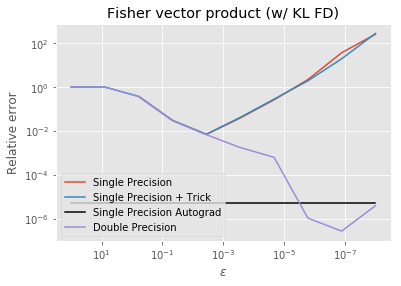

In [232]:
f = plt.figure()
plt.style.use('ggplot')
plt.xscale("log", nonposx='clip')
plt.yscale("log")#, nonposy='clip')
plt.gca().invert_xaxis()
# for i in range(len(derivStencils)):
#     means = alldiffs.mean(0)[i]
#     stds = alldiffs.std(0)[i]
#     p=plt.plot(epsValues, means)
p = plt.plot(epsValues, ad2.mean(0), label = "Single Precision")
p = plt.plot(epsValues, allfdiffs.mean(0), label = "Single Precision + Trick")
p = plt.plot(epsValues,5e-6*np.ones(len(epsValues)),color='k', label="Single Precision Autograd")
p0 = plt.plot(epsValues, ad.mean(0),label="Double Precision")

    #plt.fill_between(epsValues,means-stds,means+stds,alpha=0.2,color=p[0].get_color())
plt.ylabel("Relative error")
plt.xlabel(r'$\epsilon$')
#plt.legend(['order {}'.format(o) for o in derivStencilOrders].append("fd2"))
plt.title("Fisher vector product (w/ KL FD)")
plt.legend(loc = 3)
f.savefig("F_mvm_fd_trick.pdf", bbox_inches='tight')

In [ ]:
e =torch.load("feigs.t");el =torch.load("feigs_l.t") #auto

In [ ]:
e1 =torch.load("feigs.t");e1l =torch.load("feigs_l.t") #fd eps=1e-1

In [ ]:
#plt.axhline(0,color='k')
plt.plot(e[e.argsort()[::-1]])
plt.plot(el[el.argsort()[::-1]])
plt.legend(["linear CG", "Lanczos"])
plt.title("Eigenvalues")

In [ ]:
alldiffs = []
for _ in range(trials):
    v = flatten([torch.ones_like(p).normal_() for p in trainer.CNN.parameters()])
    q = Fvm(v,trainer.CNN,it,auto=True)
    diffs = []
    for stencil in derivStencils:
        diff = []
        for eps in epsValues:
            qq = Fvm(v,trainer.CNN,it,eps=float(eps),stencil=stencil)
            diff.append(float((qq-q).norm().cpu())/float(q.norm().cpu()))
        diffs.append(diff)
    alldiffs.append(diffs)
alldiffs = np.array(alldiffs)

In [ ]:
plt.hist(e)
plt.hist(el)

In [ ]:
plt.hist(e[(e>-25000)*(e<100000)], bins=20)

In [ ]:
#plt.hist(eigs4[(eigs4>-25000)*(eigs4<100000)], bins=20)
plt.hist(eigs5[(eigs5>-25000)*(eigs5<100000)], bins=30)
plt.legend(["fd","auto"])
plt.show()

In [ ]:
eigs5

In [ ]:
i = torch.eye(10)

In [ ]:
i[2,2]=3

In [ ]:
e,v = torch.symeig(i, eigenvectors=True)

In [ ]:
e

In [ ]:
v

In [ ]:
i.cuda().symeig()

In [ ]:
import torch

In [ ]:
a = torch.ones([32,3])
b = torch.ones([32])

In [ ]:
def partition(mbatch,k):
    b = len(mbatch[0])
    partitions = [[data[b*i//k:b*(i+1)//k] for data in mbatch] for i in range(k)]
    return partitions

In [ ]:
partition((a,b),2)[1][0].shape

In [ ]:
a